# Import

In [1]:
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.topology import all_rearangements
from tyssue.core.history import HistoryHdf5
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.basic_events import reconnect

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

import ipyvolume as ipv

In [2]:
from polarity.dynamics import model
from polarity.apoptosis import apoptosis, apoptosis_patterning
from polarity.dynamics import EllipsoidLameGeometry as geom
from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                             )
from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension, BarrierElasticity

# Working directory

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')

today = datetime.date.today().strftime('%Y%m%d')
sim_save_dir = SIM_DIR/f'{today}-QSSolver-Homogenous_Control'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

# Define solver, model and process settings

In [4]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

model = model_factory(
    [
        BarrierElasticity,
        RadialTension,
        effectors.LengthElasticity,
        effectors.LineTension,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [5]:
apopto_pattern_kwargs = {'t':0.,
                      'dt':1.,
                     'time_of_last_apoptosis':30.}

apoptosis_settings = {
        "shrink_rate": 1.1,
        "basal_shrink_rate": 1.01,
        "critical_area": 0.5,
        "contract_rate": 1.08,
        "basal_contract_rate": 1.01,
        "contract_span": 3,
        "radial_tension": 30.,
        "max_traction": 30.,
        "current_traction":0.,
        "geom": geom,
    }

# pour la propagation aux voisins
contraction_lt_kwargs = {
    'face_id':-1,
    'face':-1,
    'shrink_rate':1.05,
    'critical_area': 5.,
    "contraction_column": "line_tension",
    "model":model,
    }

 # Add events to limit rosette 
rosette_kwargs={
    'threshold_length':1e-6,
    'p_4':0.9,
    'p_5p':0.9}



# Initiate Tissue

In [6]:
sheet = init(hf5_filename='super_egg.hf5',
             json_filename = 'superegg_final.json')

sheet.settings['geometry'] = "spherical"
sheet.settings['lumen_vol_elasticity'] = 1.e-5
sheet.settings['barrier_ray'] = 100

sheet.vert_df['barrier_elasticity'] = 280.0
sheet.vert_df['radial_tension'] = 0.0

# initialy line tension was 0.6 / 1 / 1.2
sheet.edge_df.line_tension = 40.
sheet.edge_df['length_elasticity'] = 50
sheet.edge_df['prefered_length'] = 3.0

sheet.face_df['apoptosis'] = 0
sheet.face_df['current_traction'] = 0.0
sheet.face_df['radial_tension'] = 0.0

sheet.settings['apopto_pattern_kwargs'] = apopto_pattern_kwargs
sheet.settings['apoptosis'] = apoptosis_settings
sheet.settings['rosette_kwargs'] = rosette_kwargs
sheet.settings['contraction_lt_kwargs'] = contraction_lt_kwargs

geom.update_all(sheet)

In [7]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

In [8]:
define_fold_position(sheet, fold_number = 1, position=[-8, 8])
sheet.face_df.apoptosis = 0

"""apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))"""


l = [   5, 37,   71,   72, 95,  241,  384,  502,
     559,  653,  696,  706,  776, 848,  958,  985, 1008, 1075,
    1135, 1215, 1264, 1312, 1330, 1393, 1416, 1424, 1429, 1435, 1452,
    1466, 1491, 1543, 1544, 1583]
for i in l :
    sheet.face_df.loc[i, 'apoptosis']=1

/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


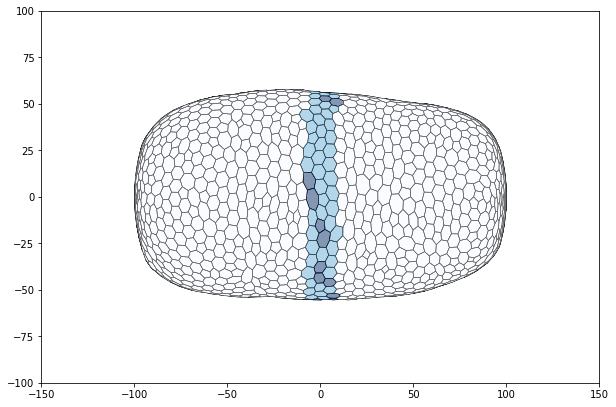

In [10]:
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':'k'
            #'color': sheet.edge_df['stress'],
            #"colormap":'bwr',
            #'color_range':(-20,20)
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis+sheet.face_df.fold,
            'colormap': 'Blues',
            'alpha':0.5

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs

sheet_=sheet.extract_bounding_box(y_boundary=(0,150))
fig, ax = sheet_view(sheet_, ['z', 'x'], mode="2D", **draw_specs(sheet_))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)

fig.set_size_inches(10,10)

In [11]:
def decrease_linear_tension_lateral(sheet, face, line_tension):
    edges = sheet.edge_df[sheet.edge_df["face"] == face]
    for index, edge in edges.iterrows():
        angle_ = np.arctan2(
            sheet.edge_df.loc[edge.name, "dx"], sheet.edge_df.loc[edge.name, "dz"]
        )
        if ( ((np.abs(angle_) < np.pi/6) and (np.abs(angle_) > -np.pi/6)) or
            ((np.abs(angle_) > -np.pi/6) and (np.abs(angle_) < np.pi/6)) or
           ((np.abs(angle_) > 5*np.pi/6) and (np.abs(angle_) < 7*np.pi/6)) or
           ((np.abs(angle_) < -7*np.pi/6) and (np.abs(angle_) > -5*np.pi/6)) ):
        
            sheet.edge_df.loc[edge.name, "line_tension"] = 24.
        else : 
            sheet.edge_df.loc[edge.name, "line_tension"] = 48.
            
def decrease_linear_tension_dv(sheet, face, line_tension):
    edges = sheet.edge_df[sheet.edge_df["face"] == face]
    for index, edge in edges.iterrows():
        angle_ = np.arctan2(
            sheet.edge_df.loc[edge.name, "dy"], sheet.edge_df.loc[edge.name, "dz"]
        )
        if ( ((np.abs(angle_) < np.pi/6) and (np.abs(angle_) > -np.pi/6)) or
            ((np.abs(angle_) > -np.pi/6) and (np.abs(angle_) < np.pi/6)) or
           ((np.abs(angle_) > 5*np.pi/6) and (np.abs(angle_) < 7*np.pi/6)) or
           ((np.abs(angle_) < -7*np.pi/6) and (np.abs(angle_) > -5*np.pi/6)) ):
            sheet.edge_df.loc[edge.name, "line_tension"] = 24.
        else : 
            sheet.edge_df.loc[edge.name, "line_tension"] = 48.
        


            

def modif_line_tension(sheet):
    sheet.edge_df['id_']= sheet.edge_df.index

    sheet2 = sheet.extract('fold')
    sheet2 = sheet2.extract_bounding_box(y_boundary=(30,150))
    [decrease_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        if sheet2.edge_df.loc[i, 'line_tension']!=15:
            sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']

    sheet2 = sheet.extract('fold')
    sheet2 = sheet2.extract_bounding_box(y_boundary=(-150,-30))
    [decrease_linear_tension_lateral(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        if sheet2.edge_df.loc[i, 'line_tension']!=15:
            sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']

    sheet2 = sheet.extract('fold')
    sheet2 = sheet2.extract_bounding_box(x_boundary=(-150,-30))
    [decrease_linear_tension_dv(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        if sheet2.edge_df.loc[i, 'line_tension']!=15:
            sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']

    sheet2 = sheet.extract('fold')
    sheet2 = sheet2.extract_bounding_box(x_boundary=(30,150))
    [decrease_linear_tension_dv(sheet2, i, 2) for i in range(sheet2.Nf)]
    for i in (sheet2.edge_df.index):
        if sheet2.edge_df.loc[i, 'line_tension']!=15:
            sheet.edge_df.loc[sheet.edge_df[sheet.edge_df.id_==sheet2.edge_df.loc[i, 'id_']].index, 'line_tension']=sheet2.edge_df.loc[i, 'line_tension']



modif_line_tension(sheet)


In [12]:
def run_sim(sim_save_dir, sheet2, shrink, constriction, radial_tension, iteration=0):
    
    # without copy, dataframe is on read only... 
    sheet = sheet2.copy()
    
    dirname = '{}_shrink_{}_constriction_{}_radialtension{}'.format(shrink,
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    # Add some information to the sheet and copy initial sheet
    sheet.face_df['id'] = sheet.face_df.index.values

    # Initiate history
    history = HistoryHdf5(sheet, 
                          extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)},
                         hf5file=os.path.join(dirname, 'out.hf5'))
    
    # Initiate manager
    manager = EventManager('face')
    

    # Update kwargs...
    sheet.settings['apoptosis'].update(
                    {'shrink_rate':shrink,
                        'contract_rate':constriction,
                    'radial_tension':radial_tension
                    })
    
    #save settings
    pd.Series(sheet.settings).to_csv(os.path.join(dirname, 'settings.csv'))
   
    
    manager.append(reconnect, **sheet.settings['rosette_kwargs'])
    manager.append(apoptosis_patterning, **sheet.settings['apopto_pattern_kwargs'])

    t = 0.
    stop = 150.
    # Run simulation
    while t < stop: 
        print('____________________________________________________________________________________')
        print(t)
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0.0

        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04.0f}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'        
        hdf5.save_datasets(hdfname, sheet)

        history.record(time_stamp=float(t))

        manager.update()
        t += 1.
        print(manager.current)
    
    
    
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [13]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()
#""" Initiale find minimal energy
# To be sure we are at the equilibrium before executing simulation 
# (it will be done only once if multiprocessing...)
#res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

radial_tension = [ 60.]

contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]
shrink_percent = [4,8,16]
shrink_rate = [1+c/100 for c in contractility_percent]


shrink_rate, contractility_rate, radial_tension = np.meshgrid(shrink_rate, contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(run_sim)(
    sim_save_dir, sheet, s, c, rd, 0) 
                             for s, c, rd in zip(shrink_rate.ravel(), contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-10-02 09:42:53.326799
end : 2019-10-02 12:58:15.232846
Duree totale d execution : 
		
3:15:21.906047
